In [104]:
%matplotlib inline

from matplotlib.pyplot import imshow
import requests
import random
import os
from keras.models import Model
from hashlib import md5
try:
    from urllib import unquote
except ImportError:
    from urllib.parse import unquote
from PIL import Image
import requests
try:
    from io import BytesIO
except ImportError:
    from StringIO import StringIO as BytesIO

import numpy as np
from tqdm import tqdm
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image

In [49]:
query = """SELECT DISTINCT ?pic
WHERE
{
    ?item wdt:P31 ?class . 
    ?class wdt:P18 ?pic
}"""

In [50]:
url = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql'
data = requests.get(url, params={'query': query, 'format': 'json'}).json()


In [51]:
images = [x['pic']['value'] for x in data['results']['bindings']]
len(images), random.sample(images, 10)

(7260,
 ['http://commons.wikimedia.org/wiki/Special:FilePath/HMS%20Koster%20%285835630935%29.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Sanfermines-vaquillas.JPG',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Quercus%20suber%20JPG1.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/LakeUnionHouseboat.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Tursiops%20truncatus%2001.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Noma%20Dojo%2C%202006.JPG',
  'http://commons.wikimedia.org/wiki/Special:FilePath/3d10%20fm%20de%20vilafranca.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Djurg%C3%A5rdsbrunn%202007.jpg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Jersey%20yellow-bluebar.svg',
  'http://commons.wikimedia.org/wiki/Special:FilePath/Ketapang%20city001.JPG'])

In [60]:
IMAGE_DIR = 'wp_images'
if not os.path.isdir(IMAGE_DIR):
    os.mkdir(IMAGE_DIR)

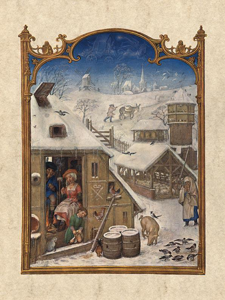

In [82]:
def fetch_image(image_cache, image_url):
    image_name = image_url.rsplit('/', 1)[-1]
    local_name = image_name.rsplit('.', 1)[0] + '.jpg'
    local_path = os.path.join(image_cache, local_name)
    if os.path.isfile(local_path):
        img = Image.open(local_path)
        img.load()
        img.thumbnail((300, 300))
        return img
    image_name = unquote(image_name).replace(' ', '_')
    m = md5()
    m.update(image_name.encode('utf8'))
    c = m.hexdigest()
    for prefix in 'http://upload.wikimedia.org/wikipedia/en', 'http://upload.wikimedia.org/wikipedia/commons':
        url = '/'.join((prefix, c[0], c[0:2], image_name))
        r = requests.get(url)
        if r.status_code != 404:
            try:
                img = Image.open(BytesIO(r.content))
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img.save(local_path)
                img.thumbnail((300, 300))
                return img
            except IOError:
                pass
    return None

fetch_image(IMAGE_DIR, images[0])

In [83]:
valid_images = []
for image_name in tqdm(images):
    img = fetch_image(IMAGE_DIR, image_name)
    if img:
        valid_images.append(img)


  1%|          | 68/7260 [00:15<15:29,  7.74it/s]  /Users/douwe/Dropbox/Douwe/Proj/notebooks/venv3/lib/python3.5/site-packages/PIL/Image.py:2244: DecompressionBombWarning: Image size (196437984 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
  8%|▊         | 589/7260 [01:41<24:17,  4.58it/s] /Users/douwe/Dropbox/Douwe/Proj/notebooks/venv3/lib/python3.5/site-packages/PIL/Image.py:2244: DecompressionBombWarning: Image size (163328704 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
 14%|█▍        | 1008/7260 [07:41<2:32:03,  1.46s/it]/Users/douwe/Dropbox/Douwe/Proj/notebooks/venv3/lib/python3.5/site-packages/PIL/Image.py:2244: DecompressionBombWarning: Image size (693930000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
 22%|██▏       | 1607/7260 [27:14<3:01:42,  1.93s/it] /Users/douwe/Dropbox/Douwe/Proj

ConnectionError: HTTPSConnectionPool(host='upload.wikimedia.org', port=443): Max retries exceeded with url: /wikipedia/commons/e/e3/Arctic_Hare_1.jpg (Caused by NewConnectionError('<requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x142acecc0>: Failed to establish a new connection: [Errno 65] No route to host',))

In [87]:
base_model = InceptionV3(weights='imagenet', include_top=True)
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_47 (Conv2D)               (None, 149, 149, 32)  864                                          
____________________________________________________________________________________________________
batch_normalization_47 (BatchNor (None, 149, 149, 32)  96                                           
____________________________________________________________________________________________________
activation_46 (Activation)       (None, 149, 149, 32)  0                                            
___________________________________________________________________________________________

In [90]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

In [79]:
del valid_images

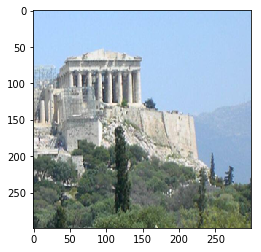

In [102]:
target_size = int(max(model.input.shape[1:]))
img = valid_images[5].resize((target_size, target_size), Image.ANTIALIAS)
imshow(np.asarray(img))

In [105]:
np_img = image.img_to_array(img)
img_batch = np.expand_dims(np_img, axis=0)
pre_processed = preprocess_input(img_batch)
pre_processed.shape

(1, 299, 299, 3)

In [110]:
def get_vector(img):
    target_size = int(max(model.input.shape[1:]))
    img = img.resize((target_size, target_size), Image.ANTIALIAS)
    np_img = image.img_to_array(img)
    img_batch = np.expand_dims(np_img, axis=0)
    pre_processed = preprocess_input(img_batch)
    return model.predict(pre_processed).flatten()

x = get_vector(valid_images[4])

In [113]:
vectors = [get_vector(img) for img in valid_images]
vectors = np.asarray(vectors)
vectors.shape

(3387, 2048)